In [96]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
%matplotlib inline

In [97]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
device = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim = 784
hidden_dim = 400
latent_dim = 2

lr = 1e-3

epochs = 20

In [98]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [99]:

"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""


class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)  # sampling epsilon
        z = mean + var * epsilon  # reparameterization trick
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))  # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var


encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [100]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()


def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [101]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  178.15405756012626
	Epoch 2 complete! 	Average Loss:  161.2770970986801
	Epoch 3 complete! 	Average Loss:  156.68508130412667
	Epoch 4 complete! 	Average Loss:  153.93383050526919
	Epoch 5 complete! 	Average Loss:  152.10579238509496
	Epoch 6 complete! 	Average Loss:  150.7376779006678
	Epoch 7 complete! 	Average Loss:  149.7385620728558
	Epoch 8 complete! 	Average Loss:  148.68039727671118
	Epoch 9 complete! 	Average Loss:  148.22509331959515
	Epoch 10 complete! 	Average Loss:  147.59061624517426
	Epoch 11 complete! 	Average Loss:  146.82071251565108
	Epoch 12 complete! 	Average Loss:  146.3479045479445
	Epoch 13 complete! 	Average Loss:  146.2053018050918
	Epoch 14 complete! 	Average Loss:  145.52860108644617
	Epoch 15 complete! 	Average Loss:  145.351945266851
	Epoch 16 complete! 	Average Loss:  145.06616827198977
	Epoch 17 complete! 	Average Loss:  144.72697901450334
	Epoch 18 complete! 	Average Loss:  144.5515017379226
	Epoc

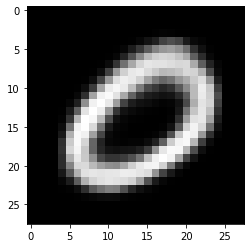

In [105]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
model.to('cpu')
with torch.no_grad():
    test_img = torch.randn(2)
    output = decoder(test_img).reshape(28, 28, 1)
    
plt.imshow(output, cmap='gray')

In [ ]:
test_img.shape

In [ ]:
test_iamges = []
nums = 20
current_img = test_img.clone().detach()
for i in range(nums):
    test_images.append(current_img)
    current_img = torch.roll(test_img, shifts=1, dims=0).clone().detach()
    if i==2:break

In [122]:
n=20
x_limit = torch.linspace(-2,2,n)
y_limit = torch.linspace(-2,2,n)
images=[]

for i, zi in enumerate(x_limit):
    for j, pi in enumerate(y_limit):
        latent_vector = torch.tensor([zi, pi]) 
        images.append(decoder(latent_vector).reshape(28,28,1).to('cpu').detach())
        
fig, ax =plt.subplots(n,n, figsize=(15,15))
nrows = n
ncols = n

c = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].imshow(images[c], cmap='gray')
        ax[i,j].axis('off')
        ax[i,j].set_aspect('equal') 
        c+=1
        
plt.subplots_adjust(wspace=0.025, hspace=0.025)

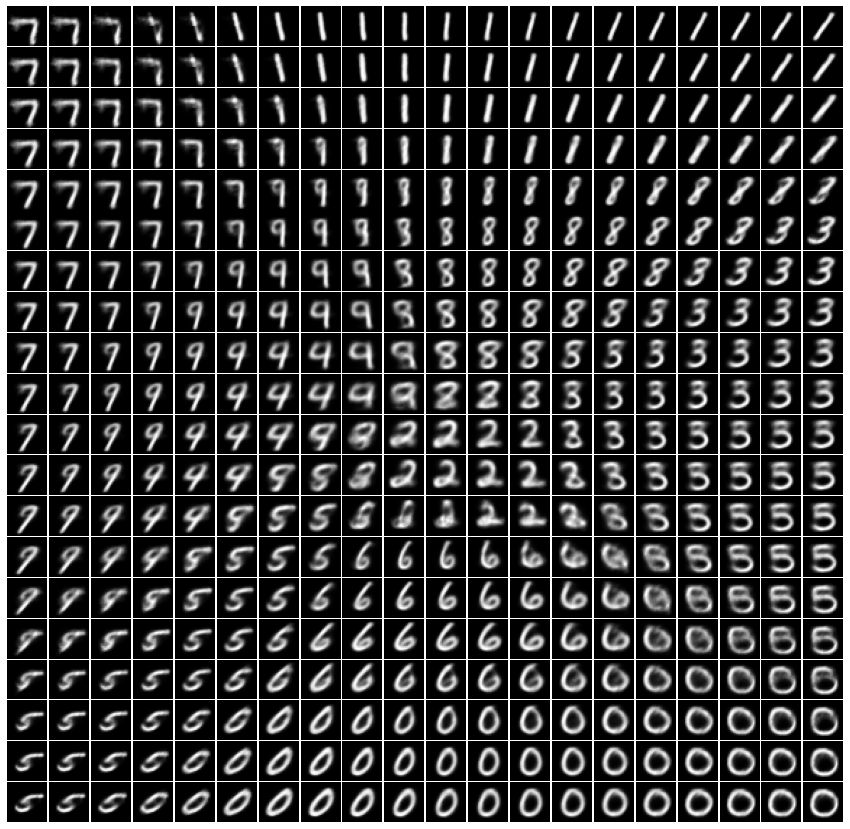